In [ ]:
#!git clone https://github.com/whyhardt/SPICE.git

In [ ]:
# !pip install -e SPICE

In [1]:
import pandas as pd
import numpy as np
from typing import Dict, List, Tuple
import matplotlib.pyplot as plt

from spice.estimator import SpiceEstimator
from spice.resources.spice_utils import SpiceConfig, SpiceDataset
from spice.utils.convert_dataset import convert_dataset
from spice.resources.rnn import BaseRNN

# For custom RNN
import torch
import torch.nn as nn

Let's load the data first with the `convert_dataset` method. This method returns a `SpiceDataset` object which we can use right away 

In [2]:
# Load your data
dataset = convert_dataset(
    file = '../../weinhardt2025/data/hwang2025/hwang2025.csv',
    df_participant_id='interaction_id',
    df_choice='SigAct_ID1',
    df_reward='Grooming_ID2',
    additional_inputs=['ID1', 'ID2', 'SigAct_ID2', 'Grooming_ID1'],
    timeshift_additional_inputs=False,
    )

# TODO: Implement dataset split into training and testing data
dataset_train, dataset_test = dataset, dataset
# blueprint for splitting:
# def datasplit(dataset, ...) -> SpiceDataset, SpiceDataset
    # return dataset_train, dataset_test
    
# structure of dataset:
# dataset has two main attributes: xs -> inputs; ys -> targets (next action)
# shape: (n_participants*n_blocks*n_experiments, n_timesteps, features)
# features are (n_actions * action, n_actions * reward, n_additional_inputs * additional_input, block_number, experiment_id, participant_id)

# in order to set up the participant embedding we have to compute the number of unique participants in our data 
# to get the number of participants n_participants we do:
n_participants = 311
n_actions = dataset.ys.shape[-1]

print(f"Shape of dataset: {dataset.xs.shape}")
print(f"Number of participants: {n_participants}")
print(f"Number of actions in dataset: {n_actions}")
print(f"Number of additional inputs: {dataset.xs.shape[-1]-2*n_actions-3}")

Shape of dataset: torch.Size([311, 144, 19])
Number of participants: 311
Number of actions in dataset: 6
Number of additional inputs: 4


### Dataset description

In [3]:
dataset.xs.shape # shape -> (n_participants: 41, timesteps: 496, features: 16)

# normal RL exp:    [A] [B] [C] [D] [E]
# choice:           [x] [ ] [ ] [ ] [ ]
# reward:           [1] [ ] [ ] [ ] [ ]    (partial feedback)
# reward:           [1] [0] [1] [1] [0]    (full feedback)

# features: (action0, action1, action2, action3, action4, reward0, reward1, reward2, reward3, reward4, 'ID2', 'SigAct_ID2', 'Grooming_ID1', block number, experiment id, ID1)
# in your case: (x, x, x, x, x, -, -, -, -, -, x, x, x, -, -, -, -, x)    -> x: keep; -: ignore

torch.Size([311, 144, 19])

Now we are going to define the configuration for SPICE with a `SpiceConfig` object.

The `SpiceConfig` takes as arguments 
1. `library_setup (dict)`: Defining the variable names of each module.
2. `memory_state (dict)`: Defining the memory state variables and their initial values.
3. `states_in_logit (list)`: Defining which of the memory state variables are used later for the logit computation. This is necessary for some background processes.  

In [4]:
spice_config = SpiceConfig(
    library_setup={
        'value_action': ['chosen', 'sig_action', 'sig_grooming', 'sig_non_contact', 'sig_contact', 'sig_scratch', 'sig_waiting', 'prev_action', 'prev_grooming', 'prev_non_contact', 'prev_contact', 'prev_scratch', 'prev_waiting'],
        'value_grooming': ['chosen', 'sig_action', 'sig_grooming', 'sig_non_contact', 'sig_contact', 'sig_scratch', 'sig_waiting', 'prev_action', 'prev_grooming', 'prev_non_contact', 'prev_contact', 'prev_scratch', 'prev_waiting'],
        'value_non_contact': ['chosen', 'sig_action', 'sig_grooming', 'sig_non_contact', 'sig_contact', 'sig_scratch', 'sig_waiting', 'prev_action', 'prev_grooming', 'prev_non_contact', 'prev_contact', 'prev_scratch', 'prev_waiting'],
        'value_contact': ['chosen', 'sig_action', 'sig_grooming', 'sig_non_contact', 'sig_contact', 'sig_scratch', 'sig_waiting', 'prev_action', 'prev_grooming', 'prev_non_contact', 'prev_contact', 'prev_scratch', 'prev_waiting'],
        'value_scratch': ['chosen', 'sig_action', 'sig_grooming', 'sig_non_contact', 'sig_contact', 'sig_scratch', 'sig_waiting', 'prev_action', 'prev_grooming', 'prev_non_contact', 'prev_contact', 'prev_scratch', 'prev_waiting'],
        'value_waiting': ['chosen', 'sig_action', 'sig_grooming', 'sig_non_contact', 'sig_contact', 'sig_scratch', 'sig_waiting', 'prev_action', 'prev_grooming', 'prev_non_contact', 'prev_contact', 'prev_scratch', 'prev_waiting'],
    },
    
    memory_state={
        # 'value_action': 0,
        # 'value_grooming': 0,
        # 'value_non_conctant': 0,
        # 'value_contact': 0,
        # 'value_scratch': 0,
        # 'waiting': 0,
        'values': 0,
        },
)

And now we are going to define the SPICE model which is a child of the `BaseRNN` and `torch.nn.Module` class and takes as required arguments:
1. `spice_config (SpiceConfig)`: previously defined SpiceConfig object
2. `n_actions (int)`: number of possible actions in your dataset (including non-displayed ones if applicable).
3. `n_participants (int)`: number of participants in your dataset.

As usual for a `torch.nn.Module` we have to define at least the `__init__` method and the `forward` method.
The `forward` method gets called when computing a forward pass through the model and takes as inputs `(inputs (SpiceDataset.xs), prev_state (dict, default: None), batch_first (bool, default: False))` and returns `(logits (torch.Tensor, shape: (n_participants*n_blocks*n_experiments, timesteps, n_actions)), updated_state (dict))`. Two necessary method calls inside the forward pass are:
1. `self.init_forward_pass(inputs, prev_state, batch_first) -> SpiceSignals`: returns a `SpiceSignals` object which carries all relevant information already processed.
2. `self.post_forward_pass(SpiceSignals, batch_first) -> SpiceSignals`: does some re-arranging of the logits to adhere to `batch_first`.

In [5]:
class SPICERNN(BaseRNN):
    
    def __init__(self, n_actions, spice_config, n_participants, **kwargs):
        super().__init__(n_actions=n_actions, spice_config=spice_config, n_participants=n_participants, embedding_size=8, **kwargs)
        
        # participant embedding
        self.participant_embedding = self.setup_embedding(num_embeddings=42, embedding_size=self.embedding_size, dropout=0.1)
        
        # rnn modules
        # reward-based modules
        self.setup_module(key_module='value_action', input_size=13+self.embedding_size*2, dropout=0.1)
        self.setup_module(key_module='value_grooming', input_size=13+self.embedding_size*2, dropout=0.1)
        self.setup_module(key_module='value_non_contact', input_size=13+self.embedding_size*2, dropout=0.1)
        self.setup_module(key_module='value_contact', input_size=13+self.embedding_size*2, dropout=0.1)
        self.setup_module(key_module='value_scratch', input_size=13+self.embedding_size*2, dropout=0.1)
        self.setup_module(key_module='value_waiting', input_size=13+self.embedding_size*2, dropout=0.1)
    
    def forward(self, inputs, prev_state, batch_first=False):
        
        spice_signals = self.init_forward_pass(inputs, prev_state, batch_first)
        
        # get participant id of Ape 2 (not implemented in spice_signals.participant_ids)
        participant_id_1 = spice_signals.additional_inputs[0, :, 0].long()
        participant_id_2 = spice_signals.additional_inputs[0, :, 1].long()
        
        # time-invariant participant features
        participant_embeddings_1 = self.participant_embedding(participant_id_1)
        participant_embeddings_2 = self.participant_embedding(participant_id_2)
        participant_embeddings = torch.concat((participant_embeddings_1, participant_embeddings_2), dim=-1)
        
        # setup all variables
        sig_action = spice_signals.actions[..., 0].unsqueeze(-1).repeat(1, 1, spice_signals.actions.shape[-1])  # make that a proper onehot-tensor; shape = (timesteps, batch, binary)
        sig_grooming = spice_signals.actions[..., 1].unsqueeze(-1).repeat(1, 1, spice_signals.actions.shape[-1])
        sig_non_contact = spice_signals.actions[..., 2].unsqueeze(-1).repeat(1, 1, spice_signals.actions.shape[-1])
        sig_contact = spice_signals.actions[..., 3].unsqueeze(-1).repeat(1, 1, spice_signals.actions.shape[-1])
        sig_scratch = spice_signals.actions[..., 4].unsqueeze(-1).repeat(1, 1, spice_signals.actions.shape[-1])
        sig_waiting = spice_signals.actions[..., 5].unsqueeze(-1).repeat(1, 1, spice_signals.actions.shape[-1])
        prev_action = torch.concat((torch.zeros((1, participant_id_1.shape[0], 1), device=self.device), spice_signals.actions[:-1, :, 0].unsqueeze(-1))).repeat(1, 1, spice_signals.actions.shape[-1])
        prev_grooming = torch.concat((torch.zeros((1, participant_id_1.shape[0], 1), device=self.device), spice_signals.actions[:-1, :, 1].unsqueeze(-1))).repeat(1, 1, spice_signals.actions.shape[-1])
        prev_non_contact = torch.concat((torch.zeros((1, participant_id_1.shape[0], 1), device=self.device), spice_signals.actions[:-1, :, 2].unsqueeze(-1))).repeat(1, 1, spice_signals.actions.shape[-1])
        prev_contact = torch.concat((torch.zeros((1, participant_id_1.shape[0], 1), device=self.device), spice_signals.actions[:-1, :, 3].unsqueeze(-1))).repeat(1, 1, spice_signals.actions.shape[-1])
        prev_scratch = torch.concat((torch.zeros((1, participant_id_1.shape[0], 1), device=self.device), spice_signals.actions[:-1, :, 4].unsqueeze(-1))).repeat(1, 1, spice_signals.actions.shape[-1])
        prev_waiting = torch.concat((torch.zeros((1, participant_id_1.shape[0], 1), device=self.device), spice_signals.actions[:-1, :, 5].unsqueeze(-1))).repeat(1, 1, spice_signals.actions.shape[-1])
        
        for timestep in spice_signals.timesteps:
            
            # update chosen value
            self.call_module(
                key_module='value_action',
                key_state='values',
                action_mask=torch.tensor((1, 0, 0, 0, 0, 0), device=self.device).reshape(1, -1).repeat(spice_signals.actions.shape[1], 1), 
                inputs=(
                    spice_signals.actions[timestep],
                    sig_action[timestep], 
                    sig_grooming[timestep], 
                    sig_non_contact[timestep], 
                    sig_contact[timestep], 
                    sig_scratch[timestep], 
                    sig_waiting[timestep], 
                    prev_action[timestep], 
                    prev_grooming[timestep], 
                    prev_non_contact[timestep], 
                    prev_contact[timestep], 
                    prev_scratch[timestep], 
                    prev_waiting[timestep],
                    ),
                participant_index=spice_signals.participant_ids,
                participant_embedding=participant_embeddings,
            )
            
            self.call_module(
                key_module='value_grooming',
                key_state='values',
                action_mask=torch.tensor((0, 1, 0, 0, 0, 0), device=self.device).reshape(1, -1).repeat(spice_signals.actions.shape[1], 1), # dummy-solution; make torch-tensor; reshape in 
                inputs=(
                    spice_signals.actions[timestep],
                    sig_action[timestep], 
                    sig_grooming[timestep], 
                    sig_non_contact[timestep], 
                    sig_contact[timestep], 
                    sig_scratch[timestep], 
                    sig_waiting[timestep], 
                    prev_action[timestep], 
                    prev_grooming[timestep], 
                    prev_non_contact[timestep], 
                    prev_contact[timestep], 
                    prev_scratch[timestep], 
                    prev_waiting[timestep],
                    ),
                participant_index=spice_signals.participant_ids,
                participant_embedding=participant_embeddings,
            )
            
            self.call_module(
                key_module='value_non_contact',
                key_state='values',
                action_mask=torch.tensor((0, 0, 1, 0, 0, 0), device=self.device).reshape(1, -1).repeat(spice_signals.actions.shape[1], 1), # dummy-solution; make torch-tensor; reshape in 
                inputs=(
                    spice_signals.actions[timestep],
                    sig_action[timestep], 
                    sig_grooming[timestep], 
                    sig_non_contact[timestep], 
                    sig_contact[timestep], 
                    sig_scratch[timestep], 
                    sig_waiting[timestep], 
                    prev_action[timestep], 
                    prev_grooming[timestep], 
                    prev_non_contact[timestep], 
                    prev_contact[timestep], 
                    prev_scratch[timestep], 
                    prev_waiting[timestep],
                    ),
                participant_index=spice_signals.participant_ids,
                participant_embedding=participant_embeddings,
            )
            
            self.call_module(
                key_module='value_contact',
                key_state='values',
                action_mask=torch.tensor((0, 0, 0, 1, 0, 0), device=self.device).reshape(1, -1).repeat(spice_signals.actions.shape[1], 1), # dummy-solution; make torch-tensor; reshape in 
                inputs=(
                    spice_signals.actions[timestep],
                    sig_action[timestep], 
                    sig_grooming[timestep], 
                    sig_non_contact[timestep], 
                    sig_contact[timestep], 
                    sig_scratch[timestep], 
                    sig_waiting[timestep], 
                    prev_action[timestep], 
                    prev_grooming[timestep], 
                    prev_non_contact[timestep], 
                    prev_contact[timestep], 
                    prev_scratch[timestep], 
                    prev_waiting[timestep],
                    ),
                participant_index=spice_signals.participant_ids,
                participant_embedding=participant_embeddings,
            )
            
            self.call_module(
                key_module='value_scratch',
                key_state='values',
                action_mask=torch.tensor((0, 0, 0, 0, 1, 0), device=self.device).reshape(1, -1).repeat(spice_signals.actions.shape[1], 1), # dummy-solution; make torch-tensor; reshape in 
                inputs=(
                    spice_signals.actions[timestep],
                    sig_action[timestep], 
                    sig_grooming[timestep], 
                    sig_non_contact[timestep], 
                    sig_contact[timestep], 
                    sig_scratch[timestep], 
                    sig_waiting[timestep], 
                    prev_action[timestep], 
                    prev_grooming[timestep], 
                    prev_non_contact[timestep], 
                    prev_contact[timestep], 
                    prev_scratch[timestep], 
                    prev_waiting[timestep],
                    ),
                participant_index=spice_signals.participant_ids,
                participant_embedding=participant_embeddings,
            )
            
            self.call_module(
                key_module='value_waiting',
                key_state='values',
                action_mask=torch.tensor((0, 0, 0, 0, 0, 1), device=self.device).reshape(1, -1).repeat(spice_signals.actions.shape[1], 1), # dummy-solution; make torch-tensor; reshape in 
                inputs=(
                    spice_signals.actions[timestep],
                    sig_action[timestep], 
                    sig_grooming[timestep], 
                    sig_non_contact[timestep], 
                    sig_contact[timestep], 
                    sig_scratch[timestep], 
                    sig_waiting[timestep], 
                    prev_action[timestep], 
                    prev_grooming[timestep], 
                    prev_non_contact[timestep], 
                    prev_contact[timestep], 
                    prev_scratch[timestep], 
                    prev_waiting[timestep],
                    ),
                participant_index=spice_signals.participant_ids,
                participant_embedding=participant_embeddings,
            )
            
            spice_signals.logits[timestep] = self.state['values']
            
        spice_signals = self.post_forward_pass(spice_signals, batch_first)
        
        return spice_signals.logits, self.get_state()

Let's setup now the `SpiceEstimator` object and fit it to the data!

In [6]:
# if epochs==4000: warmup_steps=1000; sindy_weight=1;

runs = [
    (10, 100, 0.05, 1e-2),
    #(1000, 100, 0.05, 1e-5),
    #(1000, 100, 0.05, 1e-3),
    #(1000, 100, 0.1, 1e-4),
    #(1000, 100, 0.1, 1e-5),
    #(1000, 100, 0.1, 1e-3),
    #(4000, 1000, 0.05, 1e-4),
    #(4000, 1000, 0.05, 1e-5),
    #(4000, 1000, 0.05, 1e-3),
    #(4000, 1000, 0.1, 1e-4),
    #(4000, 1000, 0.1, 1e-5),
    #(4000, 1000, 0.1, 1e-3),
]

for epochs, warmup_steps, sindy_threshold, sindy_alpha in runs:
    exp_tag = f"ep{epochs}_warm{warmup_steps}_th{sindy_threshold:g}_alpha{sindy_alpha:g}"
    save_path = f"../params/hwang2025/spice_{exp_tag}.pkl"

    estimator = SpiceEstimator(
            # model paramaeters
            rnn_class=SPICERNN,
            spice_config=spice_config,
            n_actions=6,
            # n_items=6,
            n_participants=n_participants,
            n_experiments=1,
            
            # rnn training parameters
            epochs=epochs,  # --> try: 1000 --> 4000
            warmup_steps=warmup_steps,  # if epochs==4000: warmup_steps=1000
            l2_rnn=0,#.00001,
            learning_rate=0.01,
            
            # sindy fitting parameters
            sindy_weight=0.001,
            sindy_threshold=sindy_threshold,  # try: 0.1
            sindy_threshold_frequency=1,
            sindy_threshold_terms=1,
            sindy_cutoff_patience=100,
            sindy_epochs=10,
            sindy_alpha=sindy_alpha,  # try: 0.00001, 0.001
            sindy_library_polynomial_degree=1,
            
            verbose=True,
            device=torch.device('cuda' if torch.cuda.is_available() else 'cpu'),
            save_path_spice=save_path,
        )

    #print(f"\nStarting training on {estimator.device}...")
    print(f"\nStarting training ({exp_tag}) on {estimator.device}...")
    print("=" * 80)
    estimator.fit(dataset_train.xs, dataset_train.ys, dataset_test.xs, dataset_test.ys)
    # estimator.load_spice(args.model)
    print("=" * 80)
    print("\nTraining complete!")

    # Print example SPICE model for first participant
    print("\nExample SPICE model (participant 0):")
    print("-" * 80)
    estimator.print_spice_model(participant_id=0)
    print("-" * 80)


Starting training (ep10_warm100_th0.05_alpha0.01) on cuda...

Training the RNN...
Epoch 1/10 --- L(Train): 2.4046624 --- L(Val, RNN): 2.0070868 --- L(Val, SINDy): 1.8163218 --- Time: 2.88s; --- Convergence: 1.00e+00
--------------------------------------------------------------------------------
SPICE Model (Coefficients: 90):
value_action[t+1] = -0.006 1 + 1.008 value_action[t] + 0.007 chosen + -0.008 sig_action + 0.006 sig_grooming + -0.008 sig_non_contact + 0.007 sig_contact + 0.007 sig_scratch + 0.007 sig_waiting + -0.006 prev_action + -0.007 prev_grooming + 0.008 prev_non_contact + -0.006 prev_contact + 0.006 prev_scratch + -0.006 prev_waiting 
value_grooming[t+1] = -0.006 1 + 1.007 value_grooming[t] + 0.006 chosen + 0.007 sig_action + -0.005 sig_grooming + -0.007 sig_non_contact + 0.007 sig_contact + -0.007 sig_scratch + -0.008 sig_waiting + -0.006 prev_action + -0.007 prev_grooming + 0.007 prev_non_contact + -0.007 prev_contact + -0.008 prev_scratch + 0.007 prev_waiting 
value_

In [7]:
print(estimator.rnn_model.sindy_ensemble_size)

1


In [8]:
#test

estimator = SpiceEstimator(
        # model paramaeters
        rnn_class=SPICERNN,
        spice_config=spice_config,
        n_actions=6,
        # n_items=6,
        n_participants=n_participants,
        n_experiments=1,
            
        # rnn training parameters
        epochs=10,  # --> try: 1000 --> 4000
        warmup_steps=10,  # if epochs==4000: warmup_steps=1000
        l2_rnn=0.00001,
        learning_rate=0.01,
            
        # sindy fitting parameters
        sindy_weight=0.001,
        sindy_threshold=0.05,  # try: 0.1
        sindy_threshold_frequency=1,
        sindy_threshold_terms=1,
        sindy_cutoff_patience=100,
        sindy_epochs=1000,
        sindy_alpha=0.0001,  # try: 0.00001, 0.001
        sindy_library_polynomial_degree=1,
            
        verbose=True,
        device=torch.device('cuda' if torch.cuda.is_available() else 'cpu'),
        save_path_spice=f"../params/hwang2025/test.pkl",
    )

    #print(f"\nStarting training on {estimator.device}...")
print(f"\nStarting training")
print("=" * 80)
estimator.fit(dataset_train.xs, dataset_train.ys, dataset_test.xs, dataset_test.ys)
    # estimator.load_spice(args.model)
print("=" * 80)
print("\nTraining complete!")

    # Print example SPICE model for first participant
print("\nExample SPICE model (participant 0):")
print("-" * 80)
estimator.print_spice_model(participant_id=0)
print("-" * 80)


Starting training

Training the RNN...
Epoch 1/10 --- L(Train): 2.0816371 --- L(Val, RNN): 1.7770035 --- L(Val, SINDy): 1.7924765 --- Time: 2.56s; --- Convergence: 8.89e-01
--------------------------------------------------------------------------------
SPICE Model (Coefficients: 90):
value_action[t+1] = 0.002 1 + 1.0 value_action[t] + 0.001 chosen + -0.0 sig_action + 0.0 sig_grooming + -0.0 sig_non_contact + 0.001 sig_contact + -0.002 sig_scratch + -0.001 sig_waiting + -0.002 prev_action + -0.0 prev_grooming + -0.0 prev_non_contact + 0.001 prev_contact + -0.0 prev_scratch + -0.001 prev_waiting 
value_grooming[t+1] = -0.001 1 + 0.997 value_grooming[t] + -0.001 chosen + 0.001 sig_action + 0.001 sig_grooming + 0.0 sig_non_contact + -0.001 sig_contact + 0.0 sig_scratch + -0.001 sig_waiting + -0.0 prev_action + 0.0 prev_grooming + -0.003 prev_non_contact + 0.0 prev_contact + -0.0 prev_scratch + -0.0 prev_waiting 
value_non_contact[t+1] = 0.001 1 + 1.002 value_non_contact[t] + 0.001 chosen

In [11]:
coefs = []
for module in estimator.rnn_model.sindy_coefficients.keys():
    coefs.append(estimator.rnn_model.sindy_coefficients[module].detach().cpu().numpy())
coefs = np.concatenate(coefs, axis=-1)
print(coefs.shape)

(311, 1, 1, 90)


In [12]:
print("SPICE for Ape 0 -> Ape 2:")
estimator.print_spice_model(1)

print("\nSPICE for Ape 0 -> Ape 5:")
estimator.print_spice_model(4)

SPICE for Ape 0 -> Ape 2:
value_action[t+1] = 0.081 1 + 0.477 value_action[t] + -0.062 chosen + -0.061 sig_action + 0.158 sig_grooming 
value_grooming[t+1] = 0.664 1 + 0.06 value_grooming[t] + -0.163 chosen + 0.058 sig_action + -0.15 sig_grooming 
value_non_contact[t+1] = -0.613 1 + 0.561 value_non_contact[t] 
value_contact[t+1] = 1.0 value_contact[t] 
value_scratch[t+1] = -0.542 1 + 0.335 value_scratch[t] 
value_waiting[t+1] = 0.591 1 + -0.392 value_waiting[t] + 0.239 chosen + 0.245 sig_waiting 

SPICE for Ape 0 -> Ape 5:
value_action[t+1] = 1.0 value_action[t] 
value_grooming[t+1] = 0.054 1 + 0.038 value_grooming[t] + 0.204 sig_action + 0.172 sig_waiting 
value_non_contact[t+1] = -0.953 1 + 0.267 value_non_contact[t] 
value_contact[t+1] = 1.0 value_contact[t] 
value_scratch[t+1] = -0.339 1 + 0.571 value_scratch[t] 
value_waiting[t+1] = 0.229 1 + -0.646 value_waiting[t] + 0.247 chosen + -0.368 sig_grooming + 0.247 sig_waiting 


In [13]:
# load trained model
path_model = "../params/hwang2025/spice_ep10_warm100_th0.05_alpha0.01.pkl"

estimator = SpiceEstimator(
            # model paramaeters
            rnn_class=SPICERNN,
            spice_config=spice_config,
            n_actions=6,
            # n_items=6,
            n_participants=n_participants,
            n_experiments=1,
            sindy_ensemble_size=1,
)
estimator.load_spice(path_model)

In [14]:
estimator.print_spice_model(participant_id=0)
print(estimator.rnn_model.sindy_coefficients['value_action'][0, 0] * estimator.rnn_model.sindy_coefficients_presence['value_action'][0, 0])
print(estimator.rnn_model.sindy_candidate_terms['value_action'])

value_action[t+1] = 0.065 1 + 1.003 value_action[t] + 0.001 chosen + 0.002 sig_action + 0.047 sig_grooming + -0.007 sig_non_contact + -0.002 sig_contact + -0.003 sig_scratch + 0.001 sig_waiting + 0.001 prev_action + -0.002 prev_grooming + -0.002 prev_non_contact + -0.001 prev_contact + 0.003 prev_scratch + 0.001 prev_waiting 
value_grooming[t+1] = -0.087 1 + 1.003 value_grooming[t] + 0.005 chosen + 0.001 sig_action + 0.008 sig_grooming + -0.096 sig_non_contact + 0.001 sig_contact + -0.001 sig_scratch + -0.002 sig_waiting + -0.001 prev_action + 0.002 prev_grooming + 0.001 prev_non_contact + 0.001 prev_contact + 0.001 prev_scratch + -0.002 prev_waiting 
value_non_contact[t+1] = -0.03 1 + 0.996 value_non_contact[t] + 0.097 chosen + -0.002 sig_action + -0.091 sig_grooming + 0.097 sig_non_contact + -0.002 sig_contact + -0.002 sig_scratch + -0.002 sig_waiting + 0.002 prev_action + -0.002 prev_grooming + 0.003 prev_non_contact + -0.002 prev_contact + 0.001 prev_scratch + 0.003 prev_waiting 
v

## GRU for benchmarking

### Classic GRU

In [35]:
import sys

sys.path.append('../..')
from weinhardt2025.benchmarking.benchmarking_gru import GRU, training, setup_agent_gru

path_gru = '../../weinhardt2025/params/hwang2025/gru_hwang2025.pkl'

In [36]:
epochs = 1000

gru = GRU(n_actions=n_actions, additional_inputs=4).to(torch.device('cuda' if torch.cuda.is_available() else 'cpu'))
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(gru.parameters(), lr=0.01)

In [37]:
gru = training(
    gru=gru,
    optimizer=optimizer,
    dataset_train=dataset_train,
    dataset_test=dataset_test,
    epochs=epochs,
    )

torch.save(gru.state_dict(), path_gru)
print("Trained GRU parameters saved to " + path_gru)

Epoch 1/1000: L(Train): 1.8450233936309814; L(Test): 1.615799069404602
Epoch 2/1000: L(Train): 1.6100212335586548; L(Test): 1.5714551210403442
Epoch 3/1000: L(Train): 1.5765694379806519; L(Test): 1.5537710189819336
Epoch 4/1000: L(Train): 1.5597003698349; L(Test): 1.5473741292953491
Epoch 5/1000: L(Train): 1.5524648427963257; L(Test): 1.5423420667648315
Epoch 6/1000: L(Train): 1.536084532737732; L(Test): 1.5303282737731934
Epoch 7/1000: L(Train): 1.5336699485778809; L(Test): 1.5257753133773804
Epoch 8/1000: L(Train): 1.5419871807098389; L(Test): 1.5267796516418457
Epoch 9/1000: L(Train): 1.537778377532959; L(Test): 1.5281466245651245
Epoch 10/1000: L(Train): 1.5261372327804565; L(Test): 1.528973937034607
Epoch 11/1000: L(Train): 1.5250424146652222; L(Test): 1.5277245044708252
Epoch 12/1000: L(Train): 1.531541347503662; L(Test): 1.5261781215667725
Epoch 13/1000: L(Train): 1.5367588996887207; L(Test): 1.5246026515960693
Epoch 14/1000: L(Train): 1.5256296396255493; L(Test): 1.523552060127

In [18]:
gru_agent = setup_agent_gru(path_gru, gru)

### GRU with participant embedding

In [19]:
class GRUEmbed(torch.nn.Module):
    
    def __init__(self, n_actions, n_participants, additional_inputs: int = 0, hidden_size: int = 32, **kwargs):
        super().__init__()
        
        self.gru_features = hidden_size
        self.n_actions = n_actions
        self.additional_inputs = additional_inputs
        self.embed_size = 8
        
        self.embedding = torch.nn.Embedding(n_participants, self.embed_size)
        
        self.linear_in = torch.nn.Linear(in_features=n_actions+1+additional_inputs+2*self.embed_size, out_features=hidden_size)
        self.dropout = torch.nn.Dropout(0.1)
        self.gru = torch.nn.GRU(input_size=hidden_size, hidden_size=hidden_size, batch_first=True)
        self.linear_out = torch.nn.Linear(in_features=hidden_size, out_features=n_actions)
        
    def forward(self, inputs, state=None):
        
        id1 = inputs[..., 2*self.n_actions+1].long()
        id2 = inputs[..., 2*self.n_actions+2].long()
        
        embed1 = self.embedding(id1)
        embed2 = self.embedding(id2)
        
        actions = inputs[..., :self.n_actions]
        rewards = inputs[..., self.n_actions:2*self.n_actions].nan_to_num(0).sum(dim=-1, keepdims=True)
        additional_inputs = inputs[..., self.n_actions*2+2:self.n_actions*2+2+self.additional_inputs]
        inputs = torch.concat((actions, rewards, additional_inputs, embed1, embed2), dim=-1)
        
        if state is not None and len(inputs.shape) == 3:
            state = state.reshape(1, 1, self.gru_features)
        
        y = self.linear_in(inputs.nan_to_num(0))
        y = self.dropout(y)
        y, state = self.gru(y, state)
        y = self.dropout(y)
        y = self.linear_out(y)
        return y, state


In [29]:
epochs = 1000

path_gru_embed = '../../weinhardt2025/params/hwang2025/gruembed_hwang2025.pkl'
gru_embed = GRUEmbed(n_actions=n_actions, additional_inputs=4, n_participants=n_participants).to(torch.device('cuda' if torch.cuda.is_available() else 'cpu'))
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(gru_embed.parameters(), lr=0.01)

In [30]:
gru_embed = training(
    gru=gru_embed,
    optimizer=optimizer,
    dataset_train=dataset_train,
    dataset_test=dataset_test,
    epochs=epochs,
    )

torch.save(gru_embed.state_dict(), path_gru_embed)
print("Trained GRU+Embedding parameters saved to " + path_gru_embed)

Epoch 1/1000: L(Train): 1.7963544130325317; L(Test): 1.6245155334472656
Epoch 2/1000: L(Train): 1.6320685148239136; L(Test): 1.5594172477722168
Epoch 3/1000: L(Train): 1.562958836555481; L(Test): 1.5424312353134155
Epoch 4/1000: L(Train): 1.5491691827774048; L(Test): 1.5212664604187012
Epoch 5/1000: L(Train): 1.52802312374115; L(Test): 1.499481439590454
Epoch 6/1000: L(Train): 1.528749942779541; L(Test): 1.491908073425293
Epoch 7/1000: L(Train): 1.4831535816192627; L(Test): 1.4890773296356201
Epoch 8/1000: L(Train): 1.514981985092163; L(Test): 1.4789822101593018
Epoch 9/1000: L(Train): 1.4808125495910645; L(Test): 1.4688146114349365
Epoch 10/1000: L(Train): 1.4836866855621338; L(Test): 1.4608713388442993
Epoch 11/1000: L(Train): 1.4646198749542236; L(Test): 1.4555153846740723
Epoch 12/1000: L(Train): 1.4493154287338257; L(Test): 1.4519315958023071
Epoch 13/1000: L(Train): 1.4477206468582153; L(Test): 1.4423831701278687
Epoch 14/1000: L(Train): 1.4444985389709473; L(Test): 1.43537998199

In [31]:
gru_embed_agent = setup_agent_gru(path_gru_embed, gru_embed)

## Plot choice dynamics

value_action[t+1] = 0.0 1 + 1.005 value_action[t] + -0.006 chosen + 0.003 sig_action + 0.019 sig_grooming + 0.002 sig_non_contact + -0.004 sig_contact + -0.001 sig_scratch + 0.005 sig_waiting + 0.001 prev_action + 0.001 prev_grooming + -0.002 prev_non_contact + -0.002 prev_contact + -0.001 prev_scratch + -0.001 prev_waiting 
value_grooming[t+1] = 0.107 1 + 0.893 value_grooming[t] + -0.045 chosen + 0.104 sig_action + -0.045 sig_grooming + 0.002 sig_non_contact + 0.106 sig_contact + 0.002 sig_scratch + -0.025 sig_waiting + 0.003 prev_action + -0.003 prev_grooming + -0.003 prev_non_contact + -0.001 prev_contact + -0.003 prev_scratch + 0.003 prev_waiting 
value_non_contact[t+1] = -0.107 1 + 0.934 value_non_contact[t] + 0.001 chosen + -0.003 sig_action + -0.106 sig_grooming + -0.002 sig_non_contact + 0.006 sig_contact + -0.003 sig_scratch + -0.003 sig_waiting + -0.001 prev_action + -0.002 prev_grooming + 0.001 prev_non_contact + 0.002 prev_contact + 0.001 prev_scratch + 0.002 prev_waiting 


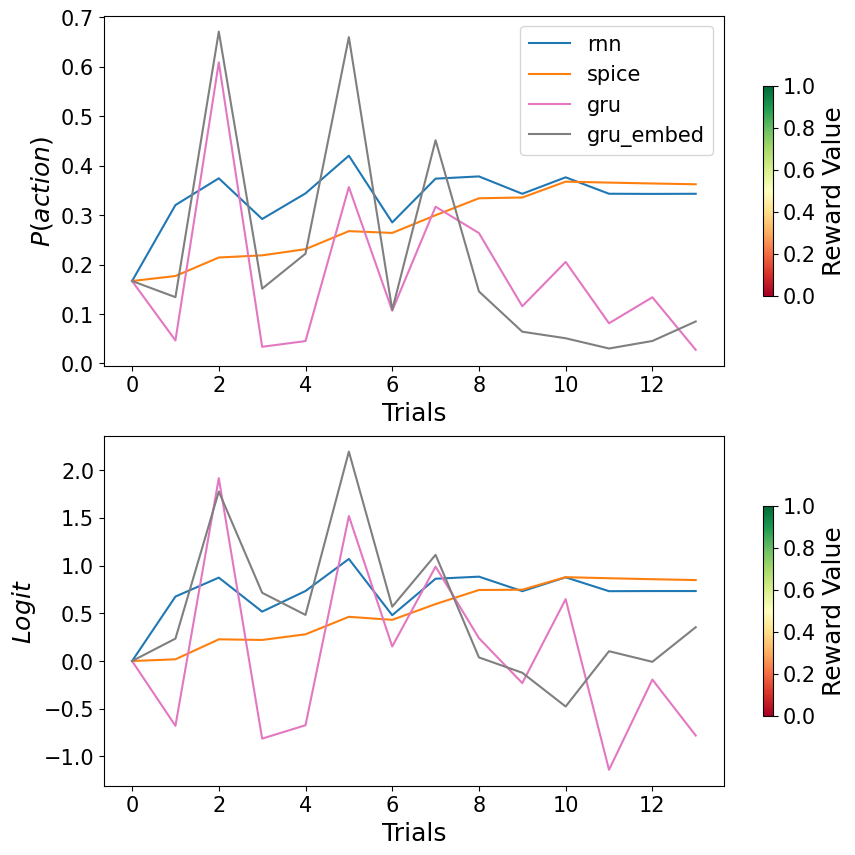

In [32]:
from spice import plot_session

# plotting
session_id = 1

estimator.print_spice_model(session_id)

agents = {
    # add baseline agent here
    'rnn': estimator.rnn_agent,
    'spice': estimator.spice_agent,
    # 'baseline': baseline_agent,
    'gru': gru_agent,
    'gru_embed': gru_embed_agent,
}

fig, axs = plot_session(agents, dataset.xs[session_id], signals_to_plot=[], display_choice=1)
plt.show()

In [34]:
# chance level predictions

num_actions = 6
num_samples = 311*144
chance_accuracy = 1 / num_actions
print(f"Chance level accuracy: {chance_accuracy:.4f} ({1/num_actions:.2%})")

# create random predictions for comparison in next cell
random_predictions = torch.randint(0, num_actions, (num_samples,))
random_predictions = torch.nn.functional.one_hot(random_predictions, num_classes=num_actions).float()

labels_flat = dataset.ys[..., 1].reshape(-1).nan_to_num(0).long()
criterion = nn.CrossEntropyLoss()

loss_random = criterion(random_predictions, labels_flat)
print(f"Random predictions loss: {loss_random.item():.4f}")

Chance level accuracy: 0.1667 (16.67%)
Random predictions loss: 1.8761


In [ ]:
# evaluate the models by getting their predictions on the real data and comparing the CE loss

estimator.rnn_model.eval(use_sindy=True)
estimator.rnn_model.init_state(batch_size=dataset.xs.shape[0])
logits_spice = estimator.rnn_model(dataset.xs, prev_state=None, batch_first=True)[0]

gru.eval()
gru.to(torch.device('cpu'))
with torch.no_grad():
    logits_gru, state_gru = gru(dataset.xs)
    
nan_mask = ~dataset.xs[:, :, 0].reshape(-1).isnan()

logits_spice_flat = logits_spice.reshape(-1, 6)
logits_gru_flat = logits_gru.reshape(-1, 6)
labels_flat = torch.argmax(dataset.ys, dim=-1).reshape(-1).nan_to_num(0).long()

criterion = nn.CrossEntropyLoss()

loss_spice = criterion(logits_spice_flat[nan_mask], labels_flat[nan_mask])
loss_gru = criterion(logits_gru_flat[nan_mask], labels_flat[nan_mask])

print(f"SPICE Loss: {loss_spice.item()}")
print(f"GRU Loss: {loss_gru.item()}")

SPICE Loss: 1.6079895496368408
GRU Loss: 1.1697009801864624


### TO-DO:

1. **implement some logic to ignore SigAct_ID1 == 5 (waiting)** 

-> nothing to predict here

-> whenever SigAct_ID1[t+1] == 5: Don't let the RNN predict because there's actually nothing to predict

2. **add reversed blocks in csv file (ID1<->ID2) to double the amount of predictable data:**

ID1,Dominan0 rank_ID1,ID2,Dominan0 rank_ID2,SigAct_ID1,SigAct_ID2,interaction_id,community_id,Grooming_ID1,Grooming_ID2

Original block:

13,13,6,6,1.0,5.0,1,0,1,0

13,13,6,6,2.0,5.0,1,0,0,0

13,13,6,6,0.0,5.0,1,0,0,0

Add reversed block:

6,6,13,13,5.0,1.0,1,0,0,1

6,6,13,13,5.0,2.0,1,0,0,0

6,6,13,13,5.0,0.0,1,0,0,0
